###Use Case C - BERT model notebook

* Revised (February 2022) to read datasets information from the database.
* Adjusted (June 2022) to read all inputs with SPARQL queries from the Knowledge Database. Also added the terms and definitions from [Eurostat's Concepts and Definitions Database](https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL_GLOSSARY&StrNom=CODED2&StrLanguageCode=EN) in the fine-tuning stage.
* This is a Google Colab notebook. You must have a Google account with a Google Drive to store/ load the model. Upload it from its location in GitHub and allow the code to access your Google Drive

###Connect Google Drive

In [1]:
## To store the model (allowing re-runs starting from re-loading the model)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installations

In [2]:
!pip install pyodbc
!pip install SPARQLWrapper
!pip install sparql_dataframe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 280 kB 9.6 MB/s 
  Created wheel for pyodbc: filename=pyodbc-4.0.32-cp37-cp37m-linux_x86_64.whl size=287326 sha256=cab2287392ce8cf98c9d04dd8e530a7602413aa18dc02b78b253681b3e5bfcec
  Stored in directory: /root/.cache/pip/wheels/2e/9c/da/8652fd42e0f662015554f00a9e96fe4f438dfd1ef59787879e
Successfully built pyodbc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 482 kB 13.9 MB/s 
     |████████████████████████████████| 41 kB 720 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libvirtodbc0 virtuoso-opensource-6.1 virtuoso-opensource-6.1-bin
  virtuoso-opensource-6.1-common virtuoso-server virtuoso-vad-conductor
  virtuoso-vsp-startpage
Suggested packages:
  virtuoso-vad-doc virtuoso-vad-demo virtuoso-vad-tutorial
  virtuoso-vad-rdfmappers virtuoso-vad-sparqldemo virtuoso-vad-syncml
  virtuoso-vad-bpel virtuoso-vad-isparql virtuoso-vad-ods virtuoso-vad-dbpedia
  virtuoso-vad-facetedbrowser
The following NEW packages will be installed:
  libvirtodbc0 virtuoso-opensource virtuoso-opensource-6.1
  virtuoso-opensource-6.1-bin virtuoso-opensource-6.1-common virtuoso-server
  virtuoso-vad-conductor virtuoso-vsp-startpage
0 upgraded, 8 newly installed, 0 to remove and 45 not upgraded.


In [4]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.4 MB/s 
     |████████████████████████████████| 4.2 MB 18.1 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 6.6 MB 26.2 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=09b1a525f1b588d17c6729c90f57985adce07881e45ed79f6ad2d27f88f8c638
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install eurostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15147 sha256=797abaff9236136b2bb82240c5e7b8cdc12d6e4feab66f4e28a869dbe4270171
  Stored in directory: /root/.cache/pip/wheels/58/88/2a/8d619cf38d7cf939e54b6ccdece05d31b64b3eb419c11d1ed3
Successfully built jsonpath-rw


### Imports and settings

In [6]:
import gensim
import pandas as pd
import numpy as np
import re
#import nltk, os

import sklearn

import ipywidgets as widgets
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
#import gzip
import torch
import random

#import pyodbc

#from collections import defaultdict
from sentence_transformers import SentenceTransformer, SentencesDataset
#from sentence_transformers.losses import TripletLoss, CosineSimilarityLoss, MultipleNegativesRankingLoss
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.readers import LabelSentenceReader, InputExample
from torch.utils.data import DataLoader

from pathlib import Path
from google.colab import data_table, drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

from SPARQLWrapper import SPARQLWrapper, POST, DIGEST, GET
#from SPARQLWrapper import JSON, INSERT, DELETE
from SPARQLWrapper import JSON
import sparql_dataframe


### Connect to the Virtuoso database

In [7]:
user = 'xxxxx'
passw = 'xxxxx'

In [8]:
def connect_virtuoso(DSN, UID, PWD):

    sparql = SPARQLWrapper(DSN)
    sparql.setHTTPAuth(DIGEST)
    sparql.setCredentials(UID, PWD)
    sparql.setMethod(GET)

    return sparql

# Connection to the KDB 
endpoint = "http://lod.csd.auth.gr:8890/sparql/"
sparql = connect_virtuoso(endpoint,user,passw)

###The data cleansing function

In [9]:
def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    #x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x

def lemmatize_text(text): ## only alphanumeric characters and drop stop-words
    return [lemmatizer.lemmatize(w).lower() for w in w_tokenizer.tokenize(text) if w.isalnum() and not w.lower() in stop
           and not re.match(r'^[0-9]+$',w) and len(w) >=5]


def lemmatize_list(x):
    str = ' '.join(x)
    return ' '.join(lemmatize_text(str))



###Select Bi-encoder model

In [10]:
# Load pre-trained model that we will use as a base for fine tuning
# By Default it loads the first in options
# Warning: loading 2nd or 3rd model for finetuning requires large amounts of memory

bi_encoder_model_dropdown = widgets.Dropdown(options=["multi-qa-MiniLM-L6-cos-v1", "multi-qa-distilbert-cos-v1", "multi-qa-mpnet-base-cos-v1"])
display(widgets.HBox([widgets.Label(value="Bi-encoder model:"), bi_encoder_model_dropdown]))

In [11]:
#We use the Bi-Encoder to encode all passages, so that we can use it with semantic search
bi_encoder = SentenceTransformer(bi_encoder_model_dropdown.value)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

### SE Glossary articles  

* Titles, URLs and definitions.
* Exclude some redirections.
* Exclude one invalid URL from a remnant empty page.

### The SPARQL query

In [12]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?title ?content where {
    ?a a estat:GlossaryArticle .
    ?a estat:title ?title .
    ?a estat:hasURL ?url.
    ?a estat:content ?content .
    filter(!regex(?content, "^(The revision|Redirect to)")) 
    filter( regex(?url, "Glossary:")) 
} 
"""
## estat:GlossaryArticle OR StatisticsExplainedArticle
  
sparql.setQuery(RelationsStatements)
sparql.method = "POST"
sparql.setReturnFormat(JSON)
GL_df = sparql.query().convert()['results']['bindings']
GL_df = pd.json_normalize(GL_df)
print(GL_df.columns)

Index(['a.type', 'a.value', 'title.type', 'title.value', 'content.type',
       'content.value'],
      dtype='object')


### Processing and cleansing

In [13]:
GL_df.rename(columns={'title.value':'title','content.value':'content'},inplace=True)
GL_df['article_id'] = range(len(GL_df))
GL_df = GL_df[['article_id','title','content']]

GL_df= GL_df.replace('', np.nan) ## Check for anything empty
print(GL_df.isnull().sum())

GL_df['title'] = GL_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['content'] = GL_df['content'].apply(clean)
GL_df

article_id    0
title         0
content       0
dtype: int64


,article_id,title,content
0,0,Accident at work,An accident at work in the framework of the ad...
1,1,Gross domestic product GDP,Gross domestic product abbreviated as GDP is a...
2,2,Toxicity,Toxicity measures the degree to which a substa...
3,3,Structural fund,The Structural funds are funding instruments t...
4,4,PRODCOM,PRODCOM is an annual survey for the collection...
...,...,...,...
1276,1276,Gross operating rate,The gross operating rate in structural busines...
1277,1277,Gross operating surplus,Gross operating surplus or profits is defined ...
1278,1278,Personnel costs,Within the context of structural business stat...
1279,1279,Stratum,In statistics a stratum plural strata refers t...


### Add paragraphs titles and contents from the SE articles

* Excluding abstracts.

### The SPARQL query

In [14]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?x ?t1 ?c where {
    ?x a estat:StatisticsExplainedArticle .
    ?x estat:hasParagraph  ?h .
    ?h estat:title ?t1 .
    FILTER(?t1!="Abstract") .
    ?h estat:content ?c .
} 
"""
  
sparql.setQuery(RelationsStatements)
sparql.method = "POST"
sparql.setReturnFormat(JSON)
add_content = sparql.query().convert()['results']['bindings']
add_content = pd.json_normalize(add_content)
print(add_content.columns)


Index(['x.type', 'x.value', 't1.type', 't1.value', 'c.type', 'c.value'], dtype='object')


### Processing and cleansing

* Also delete duplicate titles.

In [15]:
add_content.rename(columns={'t1.value':'title','c.value':'content'},inplace=True)

## add_content = add_content[['title','content']].copy()

add_content['title'] = add_content['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
add_content['content'] = add_content['content'].apply(clean)

add_content= add_content.replace('', np.nan) ## Check for anything empty
print(add_content.isnull().sum())

### DELETE NOT EXPRESSIVE TITLES!
### For safety: delete all duplicates
add_content.drop_duplicates(subset=['title'],keep=False,inplace=True)
add_content.reset_index(drop=True, inplace=True)
add_content['article_id'] = range(len(add_content))
add_content = add_content[['article_id','title','content']]
add_content

x.type     0
x.value    0
t1.type    0
title      0
c.type     0
content    0
dtype: int64


,article_id,title,content
0,0,Why is coordination important to support stati...,More and better aid requires coordination and ...
1,1,Who are the key technical and financial partne...,A wide range of international organisations an...
2,2,The technical and financial partners support t...,The PARIS21 consortium plays an important role...
3,3,Eurostat s statistical cooperation unit,Eurostat s statistical cooperation unit provid...
4,4,Official statistics in a nutshell,Definition International principles Statistics...
...,...,...,...
2775,2775,Monthly and quarterly indices,Short term business statistics provide data e ...
2776,2776,Annual overlap method,In the annual overlap method the indices for a...
2777,2777,One quarter overlap method,In the one quarter overlap method the indices ...
2778,2778,Over the year method,In the over the year method the indices for a ...


### Read OECD's terms, contexts and definitions

### The SPARQL query

In [16]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?title ?context ?definition where{
    ?a a estat:OECDTerm .
    ?a estat:term ?title .
    optional { ?a estat:context ?context }
    ?a estat:definition ?definition .
}
"""
  
sparql.setQuery(RelationsStatements)
sparql.method = "POST"
sparql.setReturnFormat(JSON)
OECD_df = sparql.query().convert()['results']['bindings']
OECD_df = pd.json_normalize(OECD_df)
print(OECD_df.columns)


Index(['a.type', 'a.value', 'title.type', 'title.value', 'context.type',
       'context.value', 'definition.type', 'definition.value'],
      dtype='object')


### Processing and cleansing

In [17]:
OECD_df.rename(columns={'title.value':'title','definition.value':'definition','context.value':'context'},inplace=True)

OECD_df.replace('',np.nan,inplace=True)
print(OECD_df.isnull().sum()) ## check for missing values

OECD_df['title'] = OECD_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
OECD_df['definition'] = OECD_df['definition'].apply(clean)
OECD_df['context'] = OECD_df['context'].apply(clean)

OECD_df['article_id'] = range(len(OECD_df))
OECD_df = OECD_df[['article_id','title','definition','context']]
OECD_df

a.type                0
a.value               0
title.type            0
title                 0
context.type       5535
context            5535
definition.type       0
definition            0
dtype: int64


,article_id,title,definition,context
0,0,Abatement cost,Abatement costs refer to expenditures which re...,The calculation of imputed abatement costs doe...
1,1,Abnormal obsolescence,Abnormal obsolescence is the loss in value of ...,Abnormal obsolescence may occur because of a n...
2,2,Abuse of dominant position,The term abuse of dominant position refers to ...,These business practices by the firm not witho...
3,3,Accessibility as a statistical data quality di...,The ease and the conditions with which statist...,Accessibility refers to the availability of st...
4,4,Accountability in management theory,A key concept in modern management theory and ...,The person or body to which the manager must r...
...,...,...,...,...
6927,6927,Zero sum game,A game played by a number of persons in which ...,NaN
6928,6928,Zero tillage,Refer No tillage,NaN
6929,6929,Zones,See Main Economic Indicator main country group...,NaN
6930,6930,Zoning,Zoning is the process in physical planning or ...,NaN


### Split into two (title,content) collections

In [18]:
# using title-definition pairs
OECD_df1 = OECD_df[['article_id','title','definition']]
OECD_df1 = OECD_df1.rename(columns={'definition':'content'})

# using title-context pairs
OECD_df2 = OECD_df[['article_id','title','context']]
OECD_df2 = OECD_df2.rename(columns={'context':'content'})

OECD_df1 = OECD_df1[['article_id','title','content']]
OECD_df2 = OECD_df2[['article_id','title','content']]

# deleting empty
OECD_df1['content'] = OECD_df1['content'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['content'])
OECD_df1['title'] = OECD_df1['title'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['title'])

OECD_df2['content'] = OECD_df2['content'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['content'])
OECD_df2['title'] = OECD_df2['title'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['title'])

In [19]:
OECD_df1

,article_id,title,content
0,0,Abatement cost,Abatement costs refer to expenditures which re...
1,1,Abnormal obsolescence,Abnormal obsolescence is the loss in value of ...
2,2,Abuse of dominant position,The term abuse of dominant position refers to ...
3,3,Accessibility as a statistical data quality di...,The ease and the conditions with which statist...
4,4,Accountability in management theory,A key concept in modern management theory and ...
...,...,...,...
6927,6927,Zero sum game,A game played by a number of persons in which ...
6928,6928,Zero tillage,Refer No tillage
6929,6929,Zones,See Main Economic Indicator main country group...
6930,6930,Zoning,Zoning is the process in physical planning or ...


In [20]:
OECD_df2

,article_id,title,content
0,0,Abatement cost,The calculation of imputed abatement costs doe...
1,1,Abnormal obsolescence,Abnormal obsolescence may occur because of a n...
2,2,Abuse of dominant position,These business practices by the firm not witho...
3,3,Accessibility as a statistical data quality di...,Accessibility refers to the availability of st...
4,4,Accountability in management theory,The person or body to which the manager must r...
...,...,...,...
6590,6590,World Wide Web WWW,Originally developed by the European Laborator...
6591,6591,Year on year changes,Also often referred to as Year over year chang...
6592,6592,Year on year YoY growth rates,Also often referred to as Year over year growt...
6593,6593,Zero coupon bonds,Zero coupon and deep discount bonds have four ...


In [21]:
del (OECD_df)

### Processing and cleansing




###Abstracts and context sections from SE articles

### The SPARQL query

In [22]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?x ?title ?url ?partitle ?context ?content where {
    ?x a estat:StatisticsExplainedArticle .
    ?x estat:title ?title .
    ?x estat:hasURL ?url .
    optional{?x estat:context ?context} .
optional {
    ?x estat:hasParagraph  ?h .
    ?h estat:title ?partitle .
    filter(?partitle="Abstract") .
    ?h estat:content ?content .
}
} 
"""

sparql.setQuery(RelationsStatements)
sparql.method = "POST"
sparql.setReturnFormat(JSON)
SE_df = sparql.query().convert()['results']['bindings']
SE_df = pd.json_normalize(SE_df)
print(SE_df.columns)


Index(['x.type', 'x.value', 'title.type', 'title.value', 'url.type',
       'url.datatype', 'url.value', 'partitle.type', 'partitle.value',
       'context.type', 'context.value', 'content.type', 'content.value'],
      dtype='object')


### Processing and cleansing

In [23]:
SE_df.rename(columns={'title.value':'title','partitle.value':'has_abstract','url.value':'url','context.value':'context','content.value':'abstract'},inplace=True)

SE_df.replace('',np.nan,inplace=True)
SE_df.replace('NaN',np.nan,inplace=True)
SE_df.replace('nan',np.nan,inplace=True)
SE_df.replace('None',np.nan,inplace=True)

print(SE_df.isnull().sum()) ## check for missing values


SE_df['article_id'] = range(len(SE_df))
SE_df = SE_df[['article_id','title','url','has_abstract','abstract','context']].copy()

SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)


SE_df

x.type             0
x.value            0
title.type         0
title              0
url.type           0
url.datatype       0
url                0
partitle.type     11
has_abstract      11
context.type     279
context          304
content.type      11
abstract          42
dtype: int64


,article_id,title,url,has_abstract,abstract,context
0,0,Chemicals production and consumption statistics,https://ec.europa.eu/eurostat/statistics-expla...,Abstract,This article presents an analysis of indicator...,The General Union Environment Action Programme...
1,1,Globalisation patterns in EU trade and investment,https://ec.europa.eu/eurostat/statistics-expla...,Abstract,NaN,NaN
2,2,Statistical cooperation European Neighbourhood...,https://ec.europa.eu/eurostat/statistics-expla...,Abstract,NaN,The ENP was developed in 2004 with the objecti...
3,3,Territorial typologies manual acknowledgements,https://ec.europa.eu/eurostat/statistics-expla...,Abstract,NaN,NaN
4,4,Statistics in development cooperation budget s...,https://ec.europa.eu/eurostat/statistics-expla...,Abstract,This article is part of a set of background ar...,NaN
...,...,...,...,...,...,...
887,887,The EU in the world transport,https://ec.europa.eu/eurostat/statistics-expla...,NaN,NaN,An efficient and well functioning passenger an...
888,888,Monthly electricity generation from non combus...,https://ec.europa.eu/eurostat/statistics-expla...,NaN,NaN,Over the last decades the effects of global wa...
889,889,Early estimates of income inequalities during ...,https://ec.europa.eu/eurostat/statistics-expla...,NaN,NaN,In the current extraordinary context of the Co...
890,890,The EU in the world business,https://ec.europa.eu/eurostat/statistics-expla...,NaN,NaN,Industrial activities such as manufacturing ar...


In [24]:

# using title-context pairs
SE_df1 = SE_df[['article_id','title','context']]
SE_df1 = SE_df1.rename(columns={'context':'content'})

# using title-abstract pairs
SE_df2 = SE_df[['article_id','title','abstract']]
SE_df2 = SE_df2.rename(columns={'abstract':'content'})

# deleting empty
SE_df1['content'] = SE_df1['content'].replace('', np.nan)
SE_df1 = SE_df1.dropna(axis=0,subset=['content'])
SE_df1.reset_index(drop=True,inplace=True)

SE_df2['content'] = SE_df2['content'].replace('', np.nan).replace('nan', np.nan)
SE_df2 = SE_df2.dropna(axis=0,subset=['content'])
SE_df2.reset_index(drop=True,inplace=True)

In [25]:
SE_df1

,article_id,title,content
0,0,Chemicals production and consumption statistics,The General Union Environment Action Programme...
1,2,Statistical cooperation European Neighbourhood...,The ENP was developed in 2004 with the objecti...
2,5,Intra EU trade exchange of micro data,International trade in goods statistics provid...
3,7,Differences between balance of payments and fo...,The EU is a major player in the global economy...
4,8,Causes of death statistics people over 65,Statistics concerning causes of death among pe...
...,...,...,...
583,887,The EU in the world transport,An efficient and well functioning passenger an...
584,888,Monthly electricity generation from non combus...,Over the last decades the effects of global wa...
585,889,Early estimates of income inequalities during ...,In the current extraordinary context of the Co...
586,890,The EU in the world business,Industrial activities such as manufacturing ar...


In [26]:
SE_df2

,article_id,title,content
0,0,Chemicals production and consumption statistics,This article presents an analysis of indicator...
1,4,Statistics in development cooperation budget s...,This article is part of a set of background ar...
2,5,Intra EU trade exchange of micro data,This article presents the innovative statistic...
3,6,EU Labour Force Survey new methodology from 20...,This article describes the methodology of the ...
4,7,Differences between balance of payments and fo...,Author Robert Obrzut Balance of payments stati...
...,...,...,...
845,880,Short term business statistics observation units,A common definition of observation units also ...
846,881,Short term business statistics quality and scope,This article presents various quality aspects ...
847,882,Short term business statistics revisions,Revisions are defined as any change in a value...
848,883,Short term business statistics seasonal adjust...,This article describes the seasonal adjustment...


In [27]:
del(SE_df)

###Eurostat's Concepts and Definitions Database

### The SPARQL query

In [28]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?term ?definition where {
    ?a a estat:CODEDTerm  .
    ?a estat:term ?term .
    ?a estat:definition ?definition .
} 
"""
sparql.setQuery(RelationsStatements)
sparql.method = "POST"
sparql.setReturnFormat(JSON)
CODED_df = sparql.query().convert()['results']['bindings']
CODED_df = pd.json_normalize(CODED_df)
print(CODED_df.columns)


Index(['a.type', 'a.value', 'term.type', 'term.value', 'definition.type',
       'definition.value'],
      dtype='object')


### Processing and cleansing

In [29]:
CODED_df.rename(columns={'term.value':'title','definition.value':'content'},inplace=True)

CODED_df.replace('',np.nan,inplace=True)
print(CODED_df.isnull().sum()) ## check for missing values


CODED_df['article_id'] = range(len(CODED_df))
CODED_df = CODED_df[['article_id','title','content']].copy()

CODED_df['title'] = CODED_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
CODED_df['content'] = CODED_df['content'].apply(clean)



CODED_df

a.type             0
a.value            0
term.type          0
title              0
definition.type    0
content            0
dtype: int64


,article_id,title,content
0,0,n k rule,A cell is regarded as confidential if the n la...
1,1,Abortion,Induced expulsion of the foetus during the fir...
2,2,Achieved sample size ratio for persons,Ratio of the number of completed personal inte...
3,3,Capital good,Capital goods are goods other than material in...
4,4,Technical expertise,A firms knowledge of and ability to use techno...
...,...,...,...
11215,11215,Taxiway,A defined path on an airport established for t...
11216,11216,Taxonomy,Classification of things according to a presum...
11217,11217,Teacher,A person employed in an official capacity for ...
11218,11218,Technical action plan for agricultural statistics,In order to improve the way in which Community...


###Merging all available glossaries and articles

In [30]:
# merge OECD glossary with add_content, GL_df and SE_df
glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2,CODED_df]
merged_glossary = pd.concat(glossaries, ignore_index=True)

del(OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2, CODED_df)

In [31]:
# setting all pairs of titles and content to have a label of 1
# this is because all pairs are considered a positive example
merged_glossary['is_pair']=1

### Analyse distribution of number of tokens (column "content")

In [32]:
tokenizer = bi_encoder.tokenizer

In [33]:
# The warning message does not affect the model, because the texts are
# automatically truncated when exceeding the maximum sequence lenth

tokens_count = []
for i in range(len(merged_glossary['content'])):
  tokens_count.append(len(tokenizer.tokenize(merged_glossary['content'][i])))

Token indices sequence length is longer than the specified maximum sequence length for this model (838 > 512). Running this sequence through the model will result in indexing errors


In [34]:
import matplotlib.pyplot as plt 


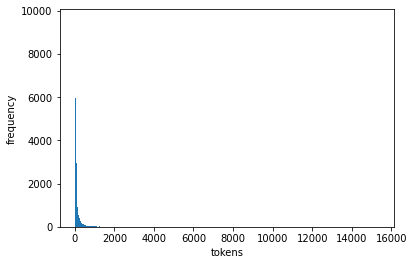

In [35]:
plt.hist(tokens_count, bins=500)
plt.ylabel('frequency')
plt.xlabel('tokens')
plt.show()

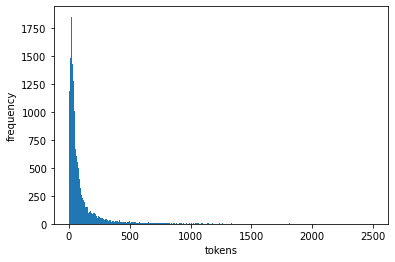

In [36]:
# "zooming in" to 0-2500 in x axis
plt.hist(tokens_count, bins=500, range=(-1, 2500))
plt.ylabel('frequency')
plt.xlabel('tokens')
plt.show()

In [37]:
tokens_count_df = pd.DataFrame(tokens_count)
tokens_count_df.describe()

,0
count,25048.000000
mean,108.721335
std,249.432087
min,2.000000
25%,22.000000
50%,44.000000
75%,99.000000
max,15382.000000


In [38]:
print(f"Number of articles that their number of words exceed the max_seq_length={bi_encoder.max_seq_length}\
 of the bi-encoder model: {len(tokens_count_df[tokens_count_df[0]>bi_encoder.max_seq_length])}/{len(tokens_count_df)}\
  ({len(tokens_count_df[tokens_count_df[0]>bi_encoder.max_seq_length])/len(tokens_count_df)*100}%)")


Number of articles that their number of words exceed the max_seq_length=512 of the bi-encoder model: 931/25048  (3.716863621846055%)


### Keep 80% of data for training and 20% for evaluation of the model

In [39]:
from sklearn.model_selection import train_test_split
train_features, eval_features, train_labels, eval_labels = train_test_split(merged_glossary[['title','content']], 
                                                                            merged_glossary[['is_pair']], 
                                                                            train_size=0.8, 
                                                                            random_state=1,
                                                                            stratify=merged_glossary['is_pair'])

In [40]:
train_features = train_features.reset_index(drop=True)
eval_features = eval_features.reset_index(drop=True)

###Fine tuning bi-encoder (CUDA required)

In [41]:
# convert training examples to the appropriate format
train_examples = []
for i in range(len(train_features)):
  train_examples.append(InputExample(texts=[train_features['title'].iloc[i], train_features['content'].iloc[i]]))

In [42]:
finetune_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [43]:
# MultipleNegativesRankingLoss is a great loss function if you only have positive pairs 
loss = MultipleNegativesRankingLoss(model=bi_encoder)

In [44]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, MSEEvaluator
from sentence_transformers import evaluation

sentences1 = list(eval_features['title'])
sentences2 = list(eval_features['content'])
scores_eval = list(eval_labels['is_pair'])

evaluator = evaluation.MSEEvaluator(sentences1, sentences2, teacher_model=bi_encoder)

In [45]:
#cleaning up any CUDA related left-overs
import gc
gc.collect()

50

In [46]:
# Fine-tune the model (BE CAREFUL TO SET A PATH FOR THE FINE-TUNED MODEL)
num_epochs = 5
bi_encoder.fit(train_objectives=[(finetune_dataloader, loss)], evaluator=evaluator, epochs=num_epochs,output_path='/content/drive/MyDrive/Data for Use Case C/testing_fine_tuning')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

###Loading the fine-tuned model

In [47]:
fine_tuned_bi_encoder = SentenceTransformer('/content/drive/MyDrive/Data for Use Case C/testing_fine_tuning')

In [48]:
bi_encoder = fine_tuned_bi_encoder

## Get results 

### Loading the datasets information from the database

* This is the parsed content of table_of_contents.xml from the bulk download facility

In [49]:
import ast
import pyodbc
c = pyodbc.connect('DRIVER=/usr/lib/odbc/virtodbc.so;HOST=lod.csd.auth.gr:1111;UID='+user+';PWD='+passw+';DATABASE=ESTAT')
#set encoding
c.setdecoding(pyodbc.SQL_CHAR, encoding='latin-1')
c.setencoding(encoding="latin-1")
cursor = c.cursor()

query = 'SELECT id, number, codes, names, file_descr, file_code, level, link FROM ESTAT.V1.dat_all_datasets'
cursor.execute(query)
t1 = cursor.fetchall()
crumbs_df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])

crumbs_df['codes'] = crumbs_df['codes'].apply(lambda x: ast.literal_eval(x))
crumbs_df['names'] = crumbs_df['names'].apply(lambda x: ast.literal_eval(x))
crumbs_df.rename(columns={'number':'Number','codes':'Codes','names':'Names','file_descr':'File description',
                               'level':'Level','file_code':'File code','link':'Link'},inplace=True)

## keep only leaves - datasets
idx = crumbs_df[crumbs_df['File code']==''].index
crumbs_df.drop(index=idx, inplace=True) 
crumbs_df.reset_index(drop=True,inplace=True)

#crumbs_df['File description']=crumbs_df['Names'].apply(lambda x: x[-1]) 

crumbs_df['Full path'] = crumbs_df['Names'].apply(lambda x: [y for y in x[1:]]) ## exclude first part

crumbs_df = crumbs_df[['Number','Codes','Names','File description','File code','Level','Full path','Link']]
crumbs_df


,Number,Codes,Names,File description,File code,Level,Full path,Link
0,1.1.1.1.1.1,"[data, general, euroind, ei_bcs, ei_bcs_cs, ei...","[Database by themes, General and regional stat...",Consumers - monthly data,ei_bsco_m,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
1,1.1.1.1.1.2,"[data, general, euroind, ei_bcs, ei_bcs_cs, ei...","[Database by themes, General and regional stat...",Consumers - quarterly data,ei_bsco_q,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
2,1.1.1.1.2.1,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Industry - monthly data,ei_bsin_m_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
3,1.1.1.1.2.2,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Industry - quarterly data,ei_bsin_q_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
4,1.1.1.1.2.3,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Construction - monthly data,ei_bsbu_m_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
...,...,...,...,...,...,...,...,...
8740,4.8.6.3.3.8,"[cc, sks, sks_dev, sks_devuoe, educ_uoe_enrt, ...","[Cross cutting topics, Skills-related statisti...",Students in tertiary education - as % of 20-24...,educ_uoe_enrt08,5,"[Skills-related statistics, Skills development...",https://ec.europa.eu/eurostat/estat-navtree-po...
8741,4.8.6.4.1,"[cc, sks, sks_dev, sks_devict, isoc_ske_ittn2]","[Cross cutting topics, Skills-related statisti...",Enterprises that provided training to develop/...,isoc_ske_ittn2,4,"[Skills-related statistics, Skills development...",https://ec.europa.eu/eurostat/estat-navtree-po...
8742,4.8.6.5.1,"[cc, sks, sks_dev, sks_devcvt, trng_cvt_01s]","[Cross cutting topics, Skills-related statisti...",Enterprises providing training by type of trai...,trng_cvt_01s,4,"[Skills-related statistics, Skills development...",https://ec.europa.eu/eurostat/estat-navtree-po...
8743,4.8.6.5.2,"[cc, sks, sks_dev, sks_devcvt, trng_cvt_12s]","[Cross cutting topics, Skills-related statisti...",Participants in CVT courses by sex and size cl...,trng_cvt_12s,4,"[Skills-related statistics, Skills development...",https://ec.europa.eu/eurostat/estat-navtree-po...


In [50]:
# Maybe drop duplicates with the same file code?
crumbs_df = crumbs_df.drop_duplicates(subset='File code', keep="first").reset_index(drop=True)
crumbs_df

,Number,Codes,Names,File description,File code,Level,Full path,Link
0,1.1.1.1.1.1,"[data, general, euroind, ei_bcs, ei_bcs_cs, ei...","[Database by themes, General and regional stat...",Consumers - monthly data,ei_bsco_m,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
1,1.1.1.1.1.2,"[data, general, euroind, ei_bcs, ei_bcs_cs, ei...","[Database by themes, General and regional stat...",Consumers - quarterly data,ei_bsco_q,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
2,1.1.1.1.2.1,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Industry - monthly data,ei_bsin_m_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
3,1.1.1.1.2.2,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Industry - quarterly data,ei_bsin_q_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
4,1.1.1.1.2.3,"[data, general, euroind, ei_bcs, ei_bcs_bs, ei...","[Database by themes, General and regional stat...",Construction - monthly data,ei_bsbu_m_r2,5,"[General and regional statistics, European and...",https://ec.europa.eu/eurostat/estat-navtree-po...
...,...,...,...,...,...,...,...,...
6812,4.6.12,"[cc, ai, tai08]","[Cross cutting topics, Agri-environmental indi...",Greenhouse gas emissions from agriculture,tai08,2,"[Agri-environmental indicators, Greenhouse gas...",https://ec.europa.eu/eurostat/estat-navtree-po...
6813,4.6.13,"[cc, ai, tai10]","[Cross cutting topics, Agri-environmental indi...",Estimated soil loss by water erosion by land c...,tai10,2,"[Agri-environmental indicators, Estimated soil...",https://ec.europa.eu/eurostat/estat-navtree-po...
6814,4.6.14,"[cc, ai, tai11]","[Cross cutting topics, Agri-environmental indi...",Share of landcover types affected by severe er...,tai11,2,"[Agri-environmental indicators, Share of landc...",https://ec.europa.eu/eurostat/estat-navtree-po...
6815,4.7.4.1,"[cc, cli, cli_iad, cli_iad_td]","[Cross cutting topics, Climate change, Impact ...",Mean near surface temperature deviation (sourc...,cli_iad_td,3,"[Climate change, Impact and adaptation, Mean n...",https://ec.europa.eu/eurostat/estat-navtree-po...


###Calculate corpus embeddings in advance

In [51]:
# We encode all corpus into our vector space, using "File description" column. 
corpus_embeddings_simple = bi_encoder.encode(crumbs_df['File description'], convert_to_tensor=True, show_progress_bar=True)

# We encode all corpus into our vector space, using "Full path" column. 
corpus_embeddings_full = bi_encoder.encode(crumbs_df['Full path'], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Batches:   0%|          | 0/214 [00:00<?, ?it/s]

In [52]:
#pre-download cross-encoder for re-ranking!
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Simple UI - Run once the chunk below then just change inputs

In [53]:
import eurostat

codes = {'hazard': 16, 'time': 1169, 'nace_r1': 888, 'geo': 4017, 
    'age691': None, 'rbd': 412, 'time1': None, 'nace_r2': 1298, 
    'worktime': 31, 'metroreg': 422, 'geo91': None, 'injury': 50, 'physact': 22, 'ceparema': 37, 
    'modinj': 11, 'train': 12, 'wrkenv': 15, 'frequenc': 61, 'tra_cov': 32, 'stk_flow': 190, 'par_mar': 302, 
    'currency': 193, 'cities': 13507, 'indic_env': 81, 'emp_cont': 17, 'loadstat': 3, 'size_emp': 31, 'airp_pr': 25160, 
    'unit': 668, 'nst07': 104, 'wat_proc': 56, 'comspec': 3, 'sex': 7, 'time91': None, 'age': 651, 
    'workproc': 9, 'age91': None, 'citizen': 4017, 'port_iww': 1032, 'source': 14, 'c_cabot': 4017, 
    'wrkstat': 5, 'c_birth': 4017, 'rep_airp': 1116, 'deviatn': 11, 'matagent': 23, 'diagnose': 28, 
    'rep_mar': 1842, 'partner': 4017, 'c_regis': 4017, 'geo1': None, 'seabasin': 12}

def relevant_datasets(query, corpus_embeddings,howmany,show_meta,show_meta_ind):

    # Encode query into our vector space 
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    top_k = 100  #Number of Eurostat databases we want to retrieve with the bi-encoder
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query
    hits_df = pd.DataFrame(hits)

    crumbs_df['corpus_id'] = crumbs_df.index
    hits_df1 = hits_df.merge(crumbs_df, on='corpus_id',how='left')
    hits_df1 = hits_df1[['corpus_id', 'score','File description', 'File code', 'Link']]

    #Re-ranking
    #Loading a cross-encoder model, and re-ranking the results of the bi-encoder
    #Cross-Encoder achieve higher performance than Bi-Encoders, however, they do not
    #scale well for large datasets. Here, it can make sense to combine Cross- and
    #Bi-Encoders, for Semantic Search scenarios: 
    #First, you use an efficient Bi-Encoder to retrieve e.g. the top-100 most
    #similar sentences for a query. Then, you use a Cross-Encoder to re-rank
    #these 100 hits by computing the score for every (query, hit) combination.

    a = hits_df1['File description']
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, a[hit]] for hit in range(len(hits_df1))]
    cross_scores = cross_encoder.predict(cross_inp)

    # sigmoid function 
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))
    # define vectorized sigmoid
    sigmoid_v = np.vectorize(sigmoid)
    cross_scores = sigmoid_v(cross_scores)

    hits_df1['cross_scores'] = cross_scores
    hits_df1 = hits_df1.sort_values(['cross_scores'],ascending=False).reset_index(drop=True)
    results = hits_df1[['corpus_id', 'cross_scores','File description', 'File code', 'Link']].head(howmany)

    hd = '<h3>Datasets descriptions in descending order of score - top '+str(howmany)+':</h3>'
    display(HTML(hd))
    display(HTML(results.to_html()))
    
    if show_meta:

        dst = pd.read_csv(results.loc[show_meta_ind,'Link'],sep='\t',low_memory=False)
        dcode=results.loc[show_meta_ind,'File code']
        dms = eurostat.get_sdmx_dims(dcode)
        h1 = '<h3>'+str(show_meta_ind)+': File code: '+dcode+'</h3>'
        h1 += '<h3>'+results.loc[show_meta_ind,'File description']+'</h3>'
        h1 += '<h3>Dimensions:</h3>'
        h1 += '  '.join('[' + x + ']' for x in dms)

        h2=''
        dims=dst.columns[0].split(',')
        dims = dims[:-1]+dims[-1].split('\\')
        
        tmp=dst.iloc[:,0].str.split(',',expand=True)

        for j in range(len(dims)-2): ## first the dimensions separated by comma
            if dims[j] not in codes.keys() or codes[dims[j]] != None:
                h2+='<h4>'+dims[j]+':</h4>'
                arr = pd.unique(tmp.iloc[:,j])
                for i in range(len(arr)):
                    h2+= '[ '+arr[i]+': '+eurostat.get_dic(dims[j])[arr[i]] +' ]'

        display(HTML(h1))
        display(HTML(h2))            
        display(HTML(dst.head().to_html()))

In [54]:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import HTML, display,clear_output

layout = widgets.Layout(width='600px', height='60px')

In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
def relevant_datasets_to_text(corpus_embeddings_full, corpus_embeddings_simple): 
    
    first_text = 'In 2021 unemployment among young people in Greece increased. This was the result of recession over the last 10 years.'  
    style = {'description_width': 'initial'}
    
    textW = widgets.Textarea(
        value=first_text, 
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='100px')
    )

    button = widgets.Button(description="Search")

    option = widgets.RadioButtons(
    options=['Simple description of datasets', 'Full-path description of datasets'],
    value='Full-path description of datasets', 
    layout={'width': 'max-content'}, 
    disabled=False
    )
    
    howmany = widgets.IntSlider(
        description='Display:',
        #tooltip='maximum:',
        value=20,
        min=1, 
        max = 30,
        style=style )
    howmany.style.handle_color = 'lightblue'
    
    show_more = widgets.Checkbox(
        value=True,
        description='Show metadata for row:',
        disabled=False,
        indent=True
     )
    
    select_ind = widgets.BoundedIntText(
        value=0,
        min=0,
        max=howmany.value-1,
        step=1,
        description='Row:',
        disabled=False,
        style={'description_width': 'initial'},
        layout = widgets.Layout(width='100px')
    )

    ui1=widgets.HBox([textW])
    ui2=widgets.HBox([option,button,howmany])
    ui3=widgets.HBox([show_more,select_ind])
    ui4=widgets.VBox([ui1,ui2,ui3])
    display(ui4, layout=Layout(align_items='center'))

    def on_button_clicked(b):
        clear_output()
        display(ui4, layout=Layout(align_items='center'))
        if option.value == 'Simple description of datasets':
            corpus_embeddings = corpus_embeddings_simple
        else:
          corpus_embeddings = corpus_embeddings_full
        relevant_datasets(textW.value,corpus_embeddings=corpus_embeddings, howmany=howmany.value,show_meta=show_more.value,show_meta_ind=select_ind.value)
       
    button.on_click(on_button_clicked)
    
    
relevant_datasets_to_text(corpus_embeddings_full, corpus_embeddings_simple)

,corpus_id,cross_scores,File description,File code,Link
0,2471,0.007349,"Unemployment rates by sex, age and citizenship (%)",lfsq_urgan,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsq_urgan.tsv.gz
1,2566,0.005358,"Unemployment rates by sex, age and country of birth (%)",lfsa_urgacob,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsa_urgacob.tsv.gz
2,2575,0.003482,Supplementary indicators to unemployment by sex and age,lfsa_sup_age,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsa_sup_age.tsv.gz
3,6541,0.003125,Unemployment rate - annual data,tipsun20,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Ftipsun20.tsv.gz
4,2384,0.001990,Supplementary indicators to unemployment - quarterly data,lfsi_sup_q,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsi_sup_q.tsv.gz
5,6542,0.001761,"Unemployment rate - quarterly data, seasonally adjusted",tipsun30,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Ftipsun30.tsv.gz
6,2571,0.001566,"Previous occupations of the unemployed, by sex (1 000)",lfsa_ugpis,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsa_ugpis.tsv.gz
7,6674,0.001125,Income share of the bottom 40 % of the population,sdg_10_50,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fsdg_10_50.tsv.gz
8,6661,0.000987,"Young people neither in employment nor in education and training (NEET), by citizenship",sdg_08_20a,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fsdg_08_20a.tsv.gz
9,6660,0.000979,Young people neither in employment nor in education and training by sex (NEET),sdg_08_20,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fsdg_08_20.tsv.gz
